# Identifying potential Bot or Paid reviewers using Amazon customer review data using Network Analysis
**By: SLT11A**
* Abel Johua Cruzada
* James Gonzales

# Executive Summary

In [108]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import networkx_abel as nxa

import regex as re
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import euclidean
from collections import Counter
from itertools import chain

from tqdm.notebook import tqdm
import warnings

In [2]:
aws_palette = ['#232f3e', '#e47911', '#007eb9', '#48a3c6', '#37475a']
sns.set_palette(palette=aws_palette)

# Introduction

# Problem Statement

# Objectives

# Data Description

# Methodology

# Data Preprocessing

## Filtering

Only include data from 2015 onwards.

In [3]:
df = pd.read_csv('amazon_reviews_video_games.csv', index_col=0)

In [4]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


Remove single value columns

In [5]:
df.nunique()

marketplace               1
customer_id          219045
review_id            330966
product_id            32693
product_parent        31366
product_title         27053
product_category          1
star_rating               5
helpful_votes           183
total_votes             246
vine                      2
verified_purchase         2
review_headline      137990
review_body          259517
review_date             243
dtype: int64

In [6]:
df.drop(['marketplace', 'product_category', 'vine'], axis=1, inplace=True)

## Text Preprocessing

Obtain word vectors using Glove

In [12]:
glove_dict = dict()
with open('embeddings/glove.6B.50d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        glove_dict[word] = vector

In [101]:
reviews = df.review_body.copy()

Set stopwords and contractions

In [8]:
stop_words = stopwords.words('english')
CONTRACTIONS = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot",
    "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will",
    "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as",
    "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have",
    "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not",
    "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have",
    "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will",
    "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not",
    "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [20]:
def text_cleaner(text):
    """
    Cleans the text by removing dates and comments.
    i.e. text enclosed in brackets and parenthesis.
    Expand contractions and remove punctations.

    Parameters
    ----------
    text : str
        Text to clean.

    Return
    ------
    token : list of str
        Tokens extracted from text after cleaning.
    """
    month_pattern = (r'jan[\w]+ |feb[\w]+ |mar[\w]+ |apr[\w]+ |may |jun[\w]+ '
                     r'|jul[\w]+ |aug[\w]+ |sep[\w]+ |oct[\w]+ |nov[\w]+ '
                     r'|dec[\w]+ ')

    clean_text = text.lower()
    clean_text = re.sub(r'[\(\)\[\]\{\}]', ' ', clean_text)
    clean_text = re.sub(month_pattern, ' ', clean_text)
    clean_text = re.sub(r'"', '', clean_text)
    clean_text = re.sub(r"'s\b", ' ', clean_text)
    clean_text = re.sub(r'[^a-zA-Z]', ' ', clean_text)
    clean_text = re.sub(r'[\ ]+', ' ', clean_text)

    clean_text = ' '.join([CONTRACTIONS[t] if t in CONTRACTIONS else t
                           for t in clean_text.split(' ')])

    return simple_preprocess(clean_text, deacc=True, min_len=2)


def remove_stopwords(words, stop_words=stop_words):
    """
    Remove stop words from the text.

    Parameters
    ----------
    words : list of str
        Words to remove stop words.
    stop_words : set of str
        Words to remove.

    Returns
    -------
    text : str
        Texts without stop words
    """
    return [word for word in words if not word in stop_words]

In [ ]:
reviews_clean = reviews.apply(lambda x: text_cleaner(str(x)))
reviews_clean = reviews_clean.apply(remove_stopwords)

In [100]:
def find_similar_term(term, n=1, threshold=5):
    """
    Find n words with similar context.
    Use Glove embeddings and euclidean distance.

    Parameters
    ----------
    term : str
        Term to find similar terms using glove embedding.
    n : int, optional
        Number of similar terms to return. default is 1.
    threshold : int, optional
        Threshold of distance to return.

    Returns
    -------
    terms : list or str
        Return a list of similar terms

    """
    if term not in glove_dict.keys():
        return []
    # Get distance
    dist = {word: euclidean(glove_dict[word], glove_dict[term])
            for word in glove_dict.keys() if word != term}
    # Filter threshold
    dist = dict(filter(lambda x: x[1] <= threshold, dist.items()))

    if len(dist):
        # Sort by distance ascending, return n number of words
        return sorted(dist.items(), key=lambda x: x[1])[:n]
    else:
        return []


def common_elements(list_1, list_2):
    """Check if two list have something in common."""
    a_set = set(list_1)
    b_set = set(list_2)
    if (a_set & b_set):
        return True
    else:
        return False

Obtain words with high frequency and Generalize terms of low frequency words

In [ ]:
# Get word count of each word
word_count = Counter(chain.from_iterable(reviews_clean.tolist()))

# Check for word count less than 10
low_freq_words = [word for word, count in word_count.items() if count <= 10]

for low_freq in tqdm(low_freq_words):
    # For each low frequency word, generalize the term
    similar_terms = [word for word, dist in find_similar_term(low_freq, 2, 3)]

    # Check if similar term has also a low frequency
    similar_terms = set(similar_terms) - set(low_freq_words)
    if len(similar_terms):
        # If a similar term is high in frequency
        # replace the word in the reviews
        similar_term = list(similar_terms)[0]
        reviews_clean = (reviews_clean
                         .loc[reviews_clean.apply(lambda x: low_freq in x)]
                         .apply(lambda words: [similar_term
                                               if x == low_freq_term else x
                                               for x in words]))
        # Remove term from low freq words
        low_freq_words.remove(low_freq)

# Remove low frequency words
mask_low_freq = reviews_clean.apply(lambda x: common_elements(x,
                                                              low_freq_words))
reviews_clean = (reviews_clean.loc[mask_low_freq]
                 .apply(lambda words: [x for x in words
                                       if x not in low_freq_words]))

# EDA

In [10]:
print(('Overall there are {} different products and variations out of {} '
       'reviews in our dataset.')
      .format(df.product_id.nunique(), df.shape[0]))

Overall there are 32693 different products and variations out of 330966 reviews in our dataset.


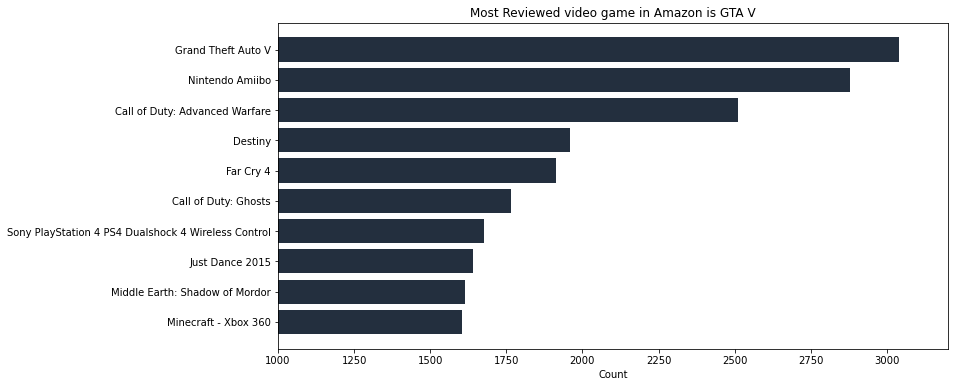

In [23]:
top10_prod = df.product_title.value_counts().head(10)
top10_prod.sort_values(inplace=True)
plt.figure(figsize=(12, 6))

plt.barh(top10_prod.index, top10_prod)
plt.title('Most Reviewed video game in Amazon is GTA V')
plt.xlabel('Count')
plt.xlim((1000, 3200))
plt.show()

The most extremely popular videogame in our dataset is GTA V and Nintendo Amiibo. With numerous reviews, it can gain the trust of potential customers based on the reviews in search of reliable opinion. Hence, it can further lead to increase in sales for the particular product.

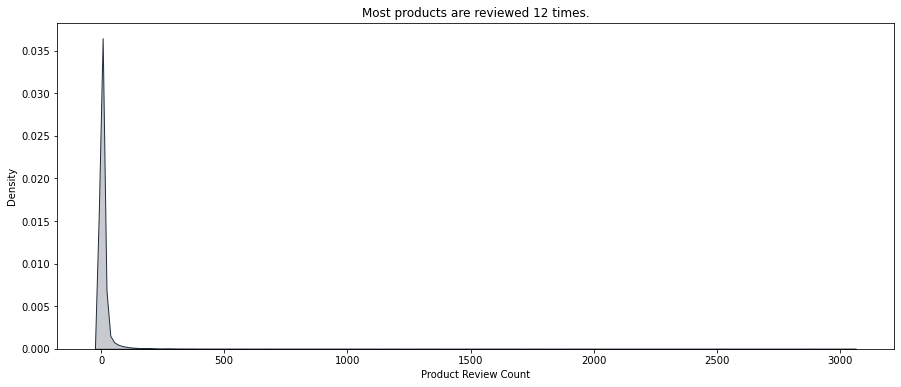

In [22]:
plt.figure(figsize=(15, 6))
sns.kdeplot(prod_counts, shade=True)
plt.title(f'Most products are reviewed {int(prod_counts.mean())} times.')
plt.xlabel('Product Review Count')
plt.show()

The plot above shows that rightly skewed distribution of product review counts. Some products are extremely popular reaching a scale of a thousand reviews, showcasing its reliability (because of many buyers/reviewers). In comparison, most of the products in the dataset are only reviewed around 12 times.

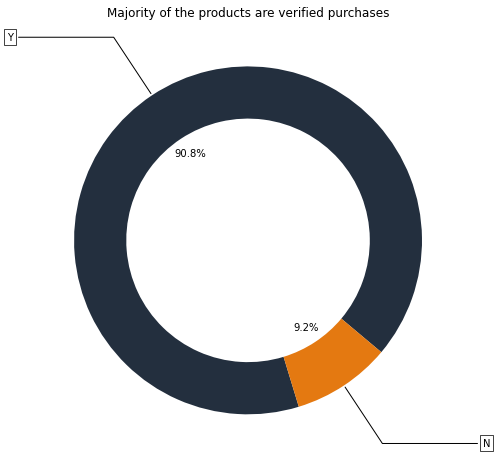

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))
data = df.verified_purchase.value_counts()

wedges, texts, pct = ax.pie(data, wedgeprops=dict(width=0.3),
                            startangle=-40, autopct="%.1f%%")

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(data.index[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title('Majority of the products are verified purchases')

plt.show()

Out of all 330966, only 30370(9.2%) reviews are tagged as verified purchase. In the following sections, we are going to further examine these reviews to determine if they are paid or bot reviews.

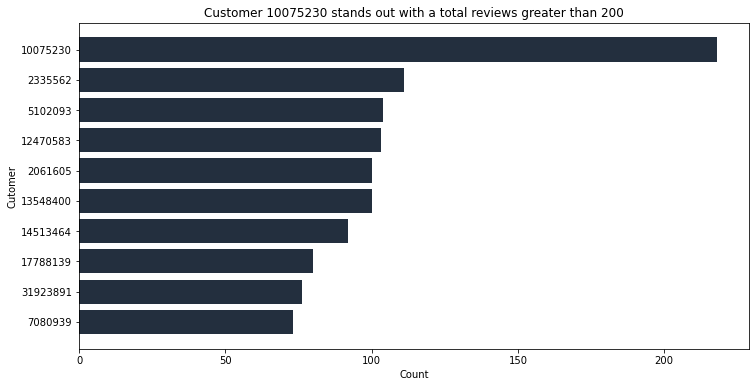

In [130]:
top10_cust = df.customer_id.value_counts().head(10)
top10_cust.sort_values(inplace=True)
plt.figure(figsize=(12, 6))

plt.barh([str(cust) for cust in top10_cust.index], top10_cust)
plt.ylabel('Cutomer')
plt.xlabel('Count')
plt.title('Customer 10075230 stands out with a total reviews greater than 200')
plt.show()

The plot above shows the number of reviews of the top 10 customers with the most reviews. Customer 10075230 stands out as the most active customer in the review section with 218 reviews in total. This customer will definitely will be a person of interest, suspected as a paid or a bot reviewer. Later in this report, we are going to the analyze the relationships of the customers using Network Analysis to see if these customers are connected.

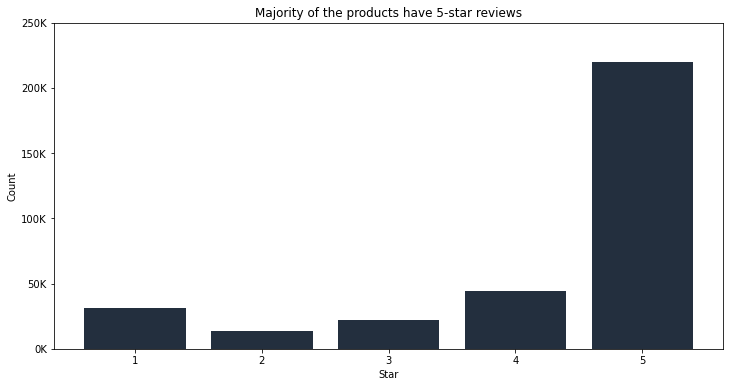

In [159]:
plt.figure(figsize=(12, 6))

plt.bar(df['star_rating'].value_counts().index,
          df['star_rating'].value_counts())
plt.ylabel('Count')
plt.xlabel('Star')
plt.title('Majority of the products have 5-star reviews')
ylabels = [f'{y/1000:.0f}K' for y in plt.gca().get_yticks()]

plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(ylabels)
plt.show()

Most of the reviews in the dataset have 5-star reviews. Either most of the products reviewed are excellent, customers are too lazy to accurately review the products, or these are fake reviews.

# FIM

customer1: {product1, product2, product3},

customer2: {product1, product2, product4}

## Confidence, Lift, Covariance

# Network

## Construct the Network

Color code based on 5 rating, scale the size of the node based on number of degrees, change the weight of the links based on prevalence of reviewed products.

## Network Properties

## Centrality Measurements

## Community Detection

# Review Information Network

## Decompose TD-IDF Matrix of review BoW features

In [12]:
def plot_variance(decomposition, title, ax, xlabel='SV'):
    """Plot latend"""
    var_exp = decomposition.explained_variance_ratio_
    ax.plot(range(1, len(var_exp)+1), var_exp, color=aws_palette[0],
            linestyle='-', marker='o', label='individual')

    ax.set_xlim(0, len(var_exp)+1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('variance explained')
    ax = ax.twinx()
    ax.plot(range(1, len(var_exp)+1),
            var_exp.cumsum(), color=aws_palette[1],
            linestyle='-', marker='o', label='cumulative')
    ax.set_ylabel('cumulative variance explained')
    ax.axhline(0.9, c='g', linestyle='dashed')
    ax.set_title(title)
    return ax

Decompose the bag of words features.

KeyboardInterrupt: 

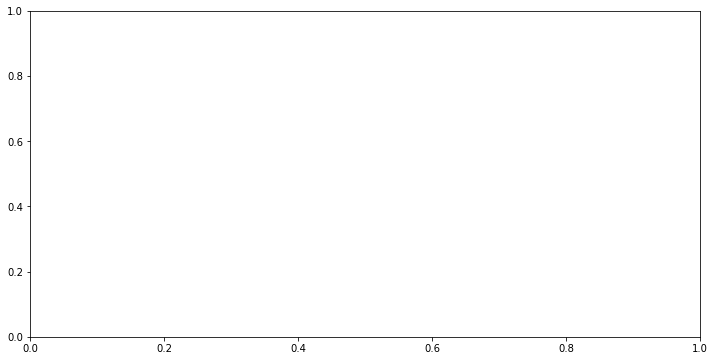

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_variance(TruncatedSVD(4000).fit(df_review_vec),
              'SVD Analysis', ax, xlabel='SV');

## Agglomorative Clustering

## Customer Review Frame Network

# Conclusion

# Recommendation

# Reference